In [7]:
import numpy as np
import pandas as pd
import tslearn
from tslearn.generators import random_walks
from tslearn.clustering import TimeSeriesKMeans
%matplotlib inline
import matplotlib.pyplot as plt

import glob, sys, os
from tqdm import tqdm

In [2]:
apsfiles = glob.glob("../../../../case_crossover/interpolate_aps/interpolated/finals/aps201[5-8]*csv")
apsfiles.sort()
for i, apsfile in enumerate(apsfiles) :
    if i == 0 :
        aps = pd.read_csv(apsfile)
    else :
        tmp = pd.read_csv(apsfile)
        aps = aps.append(tmp, ignore_index=True)
aps['date'] = pd.to_datetime(aps['date'])
aps = aps.sort_values(by='date')
aps.head()

,date,SO2,CO,O3,NO2,PM10,PM25,areacode,long_name,lon,lat,kostat_long_name,kostat_code
1643585,2015-01-01 01:00:00,0.003392,0.267511,0.026259,0.005690,22.623311,6.632959,46720,전남_곡성군,127.247088,35.202751,전남_곡성군,36320
1643558,2015-01-01 01:00:00,0.004728,0.364558,0.024094,0.006986,31.870840,9.366407,44760,충남_부여군,126.875349,36.228811,충남_부여군,34330
1643559,2015-01-01 01:00:00,0.004622,0.361491,0.024501,0.006957,32.505450,9.233095,44770,충남_서천군,126.670157,36.091826,충남_서천군,34340
1643560,2015-01-01 01:00:00,0.004668,0.387396,0.023633,0.007052,34.045092,9.576959,44790,충남_청양군,126.850286,36.442665,충남_청양군,34350
1643561,2015-01-01 01:00:00,0.004550,0.422508,0.023413,0.007420,39.390270,9.793332,44800,충남_홍성군,126.599431,36.565397,충남_홍성군,34360


#### Estimating what number of clusters is optimized
- Converting pandas df to numpy 3D array
- If any values of dataframe have nan, linear interpolate the dataframe by column-wise
- Checking whether any values in dataframe have nan
- Making sure that shape of arr is equal to (N, ts_size, 1) for input of tslearn 

In [3]:
pm25_daily_curve_sgg = aps.set_index('date')\
           .groupby('areacode')\
           .resample('D')['PM25'].mean()\
           .unstack()
print("Before interpolation")
print('PM2.5 Daily Times seris have nan?', pm25_daily_curve_sgg.isnull().values.any())
if (pm25_daily_curve_sgg.isnull().values.any()) :
    pm25_daily_curve_sgg = pm25_daily_curve_sgg.interpolate(method ='linear', 
                                                        limit_direction ='both', 
                                                        limit = 3) 
    print("After interpolation")
    print('PM2.5 Daily Times seris have nan?', pm25_daily_curve_sgg.isnull().values.any())
print("PM2.5 dataframe shape =", pm25_daily_curve_sgg.shape)
print("Short summary for PM2.5 dataframe")
print("-"*70)
print(pm25_daily_curve_sgg.head(1).iloc[:,:5])
print("-"*70)
pm25_daily_sgg_arr = pm25_daily_curve_sgg.values[:, :, np.newaxis]
print(pm25_daily_sgg_arr[0, :5, :])
print(pm25_daily_sgg_arr.shape)

Before interpolation
PM2.5 Daily Times seris have nan? True
After interpolation
PM2.5 Daily Times seris have nan? False
PM2.5 dataframe shape = (249, 1461)
Short summary for PM2.5 dataframe
----------------------------------------------------------------------
date      2015-01-01  2015-01-02  2015-01-03  2015-01-04  2015-01-05
areacode                                                            
11110       8.478261   12.041667       21.25      24.625        41.0
----------------------------------------------------------------------
[[ 8.47826087]
 [12.04166667]
 [21.25      ]
 [24.625     ]
 [41.        ]]
(249, 1461, 1)


100%|██████████| 47/47 [28:00:34<00:00, 2145.41s/it]   


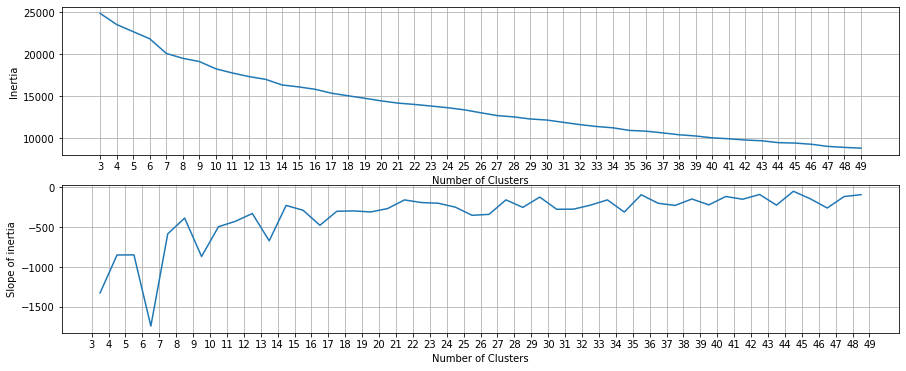

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(15, 6))
inertias = []
for j in tqdm(range(3, 50, 1)) :
    km = TimeSeriesKMeans(n_clusters=j, metric="dtw", n_jobs=4,
                          random_state=0, verbose=0).fit(pm25_daily_sgg_arr)
    inertias.append(km.inertia_)

ax[0].plot(range(3, 50, 1), inertias)
ax[0].set_xticks(range(3, 50, 1))
ax[0].grid(True, 'both')
ax[0].set_ylabel("Inertia")
ax[0].set_xlabel('Number of Clusters')
slope_inertia = []
for j in range(len(inertias)-1) :
    slope_inertia.append(inertias[j+1]-inertias[j])
ax[1].plot(np.arange(3.5, 49.5, 1), slope_inertia)
ax[1].set_xticks(range(3, 50, 1))
ax[1].grid(True, 'both')
ax[1].set_ylabel("Slope of inertia")
ax[1].set_xlabel('Number of Clusters')
plt.show()
plt.savefig("Inertia_as_a_function_of_number_of_cluster_pm2.5.png")
plt.close()

In [9]:
pm10_daily_curve_sgg = aps.set_index('date')\
           .groupby('areacode')\
           .resample('D')['PM10'].mean()\
           .unstack()
print("Before interpolation")
print('PM10 Daily Times seris have nan?', pm10_daily_curve_sgg.isnull().values.any())
if (pm10_daily_curve_sgg.isnull().values.any()) :
    pm10_daily_curve_sgg = pm10_daily_curve_sgg.interpolate(method ='linear', 
                                                        limit_direction ='both', 
                                                        limit = 3) 
    print("After interpolation")
    print('PM10 Daily Times seris have nan?', pm10_daily_curve_sgg.isnull().values.any())
print("PM10 dataframe shape =", pm10_daily_curve_sgg.shape)
print("Short summary for PM10 dataframe")
print("-"*70)
print(pm10_daily_curve_sgg.head(1).iloc[:,:5])
print("-"*70)
pm10_daily_sgg_arr = pm10_daily_curve_sgg.values[:, :, np.newaxis]
print(pm10_daily_sgg_arr[0, :5, :])
print(pm10_daily_sgg_arr.shape)

Before interpolation
PM10 Daily Times seris have nan? True
After interpolation
PM10 Daily Times seris have nan? False
PM10 dataframe shape = (249, 1461)
Short summary for PM10 dataframe
----------------------------------------------------------------------
date      2015-01-01  2015-01-02  2015-01-03  2015-01-04  2015-01-05
areacode                                                            
11110      81.913043   30.208333   41.666667   48.041667        86.5
----------------------------------------------------------------------
[[81.91304348]
 [30.20833333]
 [41.66666667]
 [48.04166667]
 [86.5       ]]
(249, 1461, 1)


100%|██████████| 47/47 [26:19:21<00:00, 2016.20s/it]   


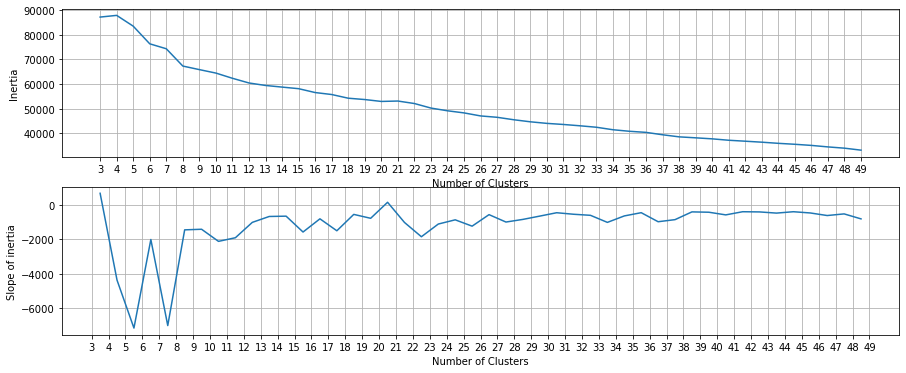

<Figure size 432x288 with 0 Axes>

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(15, 6))
inertias = []
for j in tqdm(range(3, 50, 1)) :
    km = TimeSeriesKMeans(n_clusters=j, metric="dtw", n_jobs=4,
                          random_state=0, verbose=0).fit(pm10_daily_sgg_arr)
    inertias.append(km.inertia_)

ax[0].plot(range(3, 50, 1), inertias)
ax[0].set_xticks(range(3, 50, 1))
ax[0].grid(True, 'both')
ax[0].set_ylabel("Inertia")
ax[0].set_xlabel('Number of Clusters')
slope_inertia = []
for j in range(len(inertias)-1) :
    slope_inertia.append(inertias[j+1]-inertias[j])
ax[1].plot(np.arange(3.5, 49.5, 1), slope_inertia)
ax[1].set_xticks(range(3, 50, 1))
ax[1].grid(True, 'both')
ax[1].set_ylabel("Slope of inertia")
ax[1].set_xlabel('Number of Clusters')
plt.show()
plt.savefig("Inertia_as_a_function_of_number_of_cluster_pm10.png")